In [1]:
import torch 
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
# import util
from datetime import date
import argparse
from progressbar import *
import datetime

## Config

In [87]:
# config 

num_epochs = 30
step_per_epoch = 3
n_layers = 1
likelihood = 'g'
num_obs_to_train = 30
embedding_size = 10
hidden_size = 50
seq_len = 10
batch_size=32
lr = 1e-3

## Load data

In [20]:
data = pd.read_csv('../dataset/sample_upbit_daydata.csv',parse_dates=["Unnamed: 0"])

In [21]:
# 100개 미만의 데이터가 있는 ticker는 삭제 

print(f'drop 전의 data shape: {data.shape}')
tmp = data.groupby('ticker').agg({'Unnamed: 0':'nunique'})
drop_ticker = tmp[tmp['Unnamed: 0'] < 100].index.values
print(drop_ticker)
 
drop_index = data[data['ticker'].isin(drop_ticker)].index.to_list()
data.drop(drop_index, inplace=True)
print(f'drop 후의 data shape: {data.shape}')

drop 전의 data shape: (11216, 8)
['KRW-AVAX' 'KRW-CELO' 'KRW-GMT' 'KRW-T']
drop 후의 data shape: (11000, 8)


In [22]:
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)

data['hour'] = data['date'].apply(lambda x: x.hour)
data["year"] = data["date"].apply(lambda x: x.year)
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)

features = ["hour", "day_of_week"]
# # hours = pd.get_dummies(data["hour"])
# # dows = pd.get_dummies(data["day_of_week"])
hours = data["hour"]
dows = data["day_of_week"]

In [23]:
data.dtypes

date           datetime64[ns]
ticker                 object
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
value                 float64
hour                    int64
year                    int64
day_of_week             int64
dtype: object

In [24]:
data.head()

,date,ticker,open,high,low,close,volume,value,hour,year,day_of_week
0,2022-01-29 09:00:00,KRW-BTC,46592000.0,47746000.0,46180000.0,47146000.0,3980.167762,1.862863e+11,9,2022,5
1,2022-01-30 09:00:00,KRW-BTC,47144000.0,47500000.0,46498000.0,47208000.0,2868.985234,1.350271e+11,9,2022,6
2,2022-01-31 09:00:00,KRW-BTC,47208000.0,47647000.0,45624000.0,47266000.0,4554.265206,2.112754e+11,9,2022,0
3,2022-02-01 09:00:00,KRW-BTC,47304000.0,48270000.0,46869000.0,47760000.0,3944.001610,1.874350e+11,9,2022,1
4,2022-02-02 09:00:00,KRW-BTC,47784000.0,47900000.0,45401000.0,45517000.0,4684.820468,2.192811e+11,9,2022,2


<AxesSubplot:>

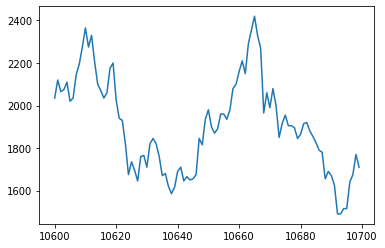

In [25]:
data[data['ticker']=='KRW-1INCH']['open'].plot()

In [26]:
data.groupby('ticker')['date'].nunique()

ticker
KRW-1INCH    100
KRW-AAVE     100
KRW-ADA      100
KRW-AERGO    100
KRW-AHT      100
            ... 
KRW-XLM      100
KRW-XRP      100
KRW-XTZ      100
KRW-ZIL      100
KRW-ZRX      100
Name: date, Length: 110, dtype: int64

### Dataset

In [15]:
from torch.utils.data import Dataset
import torch
# from torch.utils import data
from torch.utils.data import DataLoader
class WindowDataset(Dataset):
    '''
    Build a custom dataset 
    
    --Return--
    
    x: inputs
    y: targets 
    z: features
    ----------
    
    '''
    
    def __init__(self, data, input_window, output_window, stride=1):
        # total data length 
        L = data.shape[0]
        
        # total number of samples with stride
        num_samples = (L - input_window - output_window) // stride + 1
        
        # input, output 
        X = []
        Y = []
        Xf = []
        Yf = []
        
        for i in range(num_samples):
            start_x = stride*i
            end_x = start_x + input_window 
            Y.append(data.iloc[start_x: end_x, 0].values)
            X.append(data.iloc[start_x: end_x, 1:].values)
            start_y = stride*i + input_window
            end_y = start_y + output_window 
            Yf.append(data.iloc[start_y:end_y, 0].values)
            Xf.append(data.iloc[start_y:end_y, 1:].values)
            
        self.X = X
        self.Y = Y
        self.Xf = Xf
        self.Yf = Yf
        
        self.len = len(X)
            
    def __len__(self):
        return self.len 
    
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.X[idx])
        Y = torch.FloatTensor(self.Y[idx])
        Y = Y.unsqueeze(-1)
        Xf = torch.FloatTensor(self.Xf[idx])
        Yf = torch.FloatTensor(self.Yf[idx])
        Yf = Yf.unsqueeze(-1)
        
        return X, Y, Xf, Yf

In [35]:
tmp = data[data['ticker']=='KRW-BTC']
tmp = tmp[['open','hour','day_of_week']]
tmp.head(1)

,open,hour,day_of_week
0,46592000.0,9,5


In [42]:
custom_dataset = WindowDataset(tmp, 30, 10, 1)
train_dataloader = DataLoader(custom_dataset, batch_size=32)

In [43]:
X,Y,Xf,Yf = next(iter(train_dataloader))

In [44]:
X.shape

torch.Size([32, 30, 2])

In [45]:
Y.shape

torch.Size([32, 30, 1])

In [46]:
Xf.shape

torch.Size([32, 10, 2])

In [47]:
Yf.shape

torch.Size([32, 10, 1])

### Scaler function option 

In [59]:
# scaler

class MeanScaler:
    
    def fit_transform(self, y):
        self.mean = np.mean(y)
        return y / self.mean
    
    def inverse_transform(self, y):
        return y * self.mean

    def transform(self, y):
        return y / self.mean

class StandardScaler:
    
    def fit_transform(self, y):
        self.mean = np.mean(y)
        self.std = np.std(y) + 1e-4
        return (y - self.mean) / self.std
    
    def inverse_transform(self, y):
        return y * self.std + self.mean

    def transform(self, y):
        return (y - self.mean) / self.std

## Model

In [60]:
class Gaussian(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)

        # initialize weights
        # nn.init.xavier_uniform_(self.mu_layer.weight)
        # nn.init.xavier_uniform_(self.sigma_layer.weight)
    
    def forward(self, h):
        _, hidden_size = h.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        sigma_t = sigma_t.squeeze(0)
        mu_t = self.mu_layer(h).squeeze(0)
        return mu_t, sigma_t

def gaussian_sample(mu, sigma):
    '''
    Gaussian Sample
    Args:
    ytrue (array like)
    mu (array like)
    sigma (array like): standard deviation
    gaussian maximum likelihood using log 
        l_{G} (z|mu, sigma) = (2 * pi * sigma^2)^(-0.5) * exp(- (z - mu)^2 / (2 * sigma^2))
    '''
    # likelihood = (2 * np.pi * sigma ** 2) ** (-0.5) * \
    #         torch.exp((- (ytrue - mu) ** 2) / (2 * sigma ** 2))
    # return likelihood
    gaussian = torch.distributions.normal.Normal(mu, sigma)
    ypred = gaussian.sample()
    if ypred.dim() == 1:
        ypred = ypred.unsqueeze(0)
    return ypred

def gaussian_likelihood_loss(z, mu, sigma):
    '''
    Gaussian Liklihood Loss
    Args:
    z (tensor): true observations, shape (num_ts, num_periods)
    mu (tensor): mean, shape (num_ts, num_periods)
    sigma (tensor): standard deviation, shape (num_ts, num_periods)
    likelihood: 
    (2 pi sigma^2)^(-1/2) exp(-(z - mu)^2 / (2 sigma^2))
    log likelihood:
    -1/2 * (log (2 pi) + 2 * log (sigma)) - (z - mu)^2 / (2 sigma^2)
    '''
    negative_likelihood = torch.log(sigma + 1) + (z - mu) ** 2 / (2 * sigma ** 2) + 6
    return negative_likelihood.mean()

In [61]:
class DeepAR(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, lr=1e-3, likelihood="g"):
        super(DeepAR, self).__init__()

        # network
        self.input_embed = nn.Linear(1, embedding_size)
        self.encoder = nn.LSTM(embedding_size+input_size, hidden_size, \
                num_layers, bias=True, batch_first=True)
        if likelihood == "g":
            self.likelihood_layer = Gaussian(hidden_size, 1)

        self.likelihood = likelihood

    def forward(self, X, y, Xf):
        num_ts, seq_len, _ = X.size() # 64, 168, 2
        _, output_horizon, num_features = Xf.size() # 64, 60, 2

        ynext = None
        ypred = []
        mus = []
        sigmas = []       
        h, c = None, None
        for s in range(seq_len + output_horizon):
            if s < seq_len:
                ynext = y[:, s].view(-1, 1) # (batch_size, 1) 
                yembed = self.input_embed(ynext).view(num_ts, -1) # (batch_size, embed_size)
                x = X[:, s, :].view(num_ts, -1) # (batch_size, num_feature)
            else:
                yembed = self.input_embed(ynext).view(num_ts, -1) # (batch_size, embed_size)
                x = Xf[:, s-seq_len, :].view(num_ts, -1) # (batch_size, num_feature)
            x = torch.cat([x, yembed], dim=1) # (batch_size, num_feature+embed_size)
            inp = x.unsqueeze(1) # (batch_size, 1, num_feature+embed_size)
            if h is None and c is None:
                out, (h, c) = self.encoder(inp) # h size (num_layers, num_ts, hidden_size)
            else:
                out, (h, c) = self.encoder(inp, (h, c))

            hs = h[-1, :, :] # (batch_size, hidden_size)
            hs = F.relu(hs)
            mu, sigma = self.likelihood_layer(hs)
            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))
            if self.likelihood == 'g':
                ynext = gaussian_sample(mu, sigma)

            if s >= seq_len - 1 and s < output_horizon + seq_len - 1:
                ypred.append(ynext)
                
        ypred = torch.cat(ypred, dim=1).view(num_ts, -1)
        mu = torch.cat(mus, dim=1).view(num_ts, -1)
        sigma = torch.cat(sigmas, dim=1).view(num_ts, -1)
        return ypred, mu, sigma   
        

## Train

In [64]:
# metric

def MAPE(ytrue, ypred):
    ytrue = np.array(ytrue).ravel() + 1e-4
    ypred = np.array(ypred).ravel()
    return np.mean(np.abs((ytrue - ypred) \
        / ytrue))

def MAPEval(y_pred, y_true):
    y_true = np.array(y_true).ravel() + 1e-4
    y_pred = np.array(y_pred).ravel()    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### train test split 

In [63]:
# KRW-GAS 제외 전부 train 
# KRW-GAS만 test

train_data = data[data['ticker']!='KRW-GAS']
test_data = data[data['ticker']=='KRW-GAS']

In [86]:
def train(train_data, test_data):
    # num_ts, num_periods, num_features = X.shape
    model = DeepAR(2, embedding_size, 
        hidden_size, n_layers)

    optimizer = Adam(model.parameters(), lr=lr)
    random.seed(42)
    
    total_losses = []
    cnt = 0

    ticker_lst = train_data.ticker.unique().tolist()
    
    for ticker in ticker_lst:
        print(f'=========={ticker}==========')

        losses = []

        data_tr = train_data[train_data['ticker']==ticker]
        data_tr = data_tr[['open', 'hour', 'day_of_week']]
        data_tr.reset_index(drop=True, inplace=True)

        yscaler = MeanScaler()
        tmp = yscaler.fit_transform(data_tr['open'])
        data_tr['open'] = tmp

        custom_dataset = WindowDataset(data_tr, num_obs_to_train, seq_len)
        train_dataloader = DataLoader(custom_dataset, batch_size)

        #-- train
        progress = ProgressBar()     

        for epoch in progress(range(num_epochs)):
            for X, Y, Xf, Yf in train_dataloader:
                ypred, mu, sigma = model(X, Y, Xf)
                ytrain_tensor = torch.cat([Y, Yf], dim=1)
                z = ytrain_tensor.squeeze(2)
                loss = gaussian_likelihood_loss(z, mu, sigma)
                losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                cnt += 1  

        total_losses.append(losses)
        
    #-- test 
    mape_list = []
    data_te = test_data[['open', 'hour', 'day_of_week']]
    data_te.reset_index(drop=True, inplace=True)

    tmp = yscaler.transform(data_te['open'])
    data_te['open'] = tmp   

    custom_dataset = WindowDataset(data_te, num_obs_to_train, seq_len)
    test_dataloader = DataLoader(custom_dataset, 1)

    X_te, Y_te, Xf_te, Yf_te = next(iter(test_dataloader))  

    n_samples = 100
    result = []
    for _ in tqdm(range(n_samples)):
        y_pred, _, _ = model(X_te, Y_te, Xf_te)
        y_pred = y_pred.data.numpy()
        y_pred = yscaler.inverse_transform(y_pred)

        result.append(y_pred.reshape((-1,1)))

    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p60 = np.quantile(result, 0.6, axis=1)
    p40 = np.quantile(result, 0.4, axis=1)     

    y_true = yscaler.inverse_transform(Yf_te.data.numpy())
    mape = MAPEval(p50, y_true)
    print("P50 MAPE: {}".format(mape))
    mape_list.append(mape)    

    Y_total = torch.concat([Y_te, Yf_te], dim=1)
    Y_total = yscaler.inverse_transform(Y_total.data.numpy())
    plt.figure(1, figsize=(20, 5))
    plt.plot([k + seq_len + num_obs_to_train - seq_len \
        for k in range(seq_len)], p50, "r-")
    plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
        y1=p40, y2=p60, alpha=0.5)
    plt.title('Prediction uncertainty')
    yplot = Y_total[-1, -seq_len-num_obs_to_train:]
    plt.plot(range(len(yplot)), yplot, "k-")
    plt.legend(["P50 forecast", "P40-P60 quantile", "true"], loc="upper left")
    ymin, ymax = plt.ylim()
    plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
    plt.ylim(ymin, ymax)
    plt.xlabel("Periods")
    plt.ylabel("Y")
    # plt.show()
    plt.savefig(f'../img/deepar_pred_version2.png')

    return total_losses, mape_list, p50, y_true     


==========KRW-BTC==========


100% |########################################################################|


==========KRW-ETH==========


100% |########################################################################|


==========KRW-NEO==========


100% |########################################################################|


==========KRW-MTL==========


100% |########################################################################|


==========KRW-LTC==========


100% |########################################################################|


==========KRW-XRP==========


100% |########################################################################|


==========KRW-ETC==========


100% |########################################################################|


==========KRW-OMG==========


100% |########################################################################|


==========KRW-SNT==========


100% |########################################################################|


==========KRW-WAVES==========


100% |########################################################################|


==========KRW-XEM==========


100% |########################################################################|


==========KRW-QTUM==========


100% |########################################################################|


==========KRW-LSK==========


100% |########################################################################|


==========KRW-STEEM==========


100% |########################################################################|


==========KRW-XLM==========


100% |########################################################################|


==========KRW-ARDR==========


100% |########################################################################|


==========KRW-ARK==========


100% |########################################################################|


==========KRW-STORJ==========


100% |########################################################################|


==========KRW-GRS==========


100% |########################################################################|


==========KRW-REP==========


100% |########################################################################|


==========KRW-ADA==========


100% |########################################################################|


==========KRW-SBD==========


100% |########################################################################|


==========KRW-POWR==========


100% |########################################################################|


==========KRW-BTG==========


100% |########################################################################|


==========KRW-ICX==========


100% |########################################################################|


==========KRW-EOS==========


100% |########################################################################|


==========KRW-TRX==========


100% |########################################################################|


==========KRW-SC==========


100% |########################################################################|


==========KRW-ONT==========


100% |########################################################################|


==========KRW-ZIL==========


100% |########################################################################|


==========KRW-POLY==========


100% |########################################################################|


==========KRW-ZRX==========


100% |########################################################################|


==========KRW-LOOM==========


100% |########################################################################|


==========KRW-BCH==========


100% |########################################################################|


==========KRW-BAT==========


100% |########################################################################|


==========KRW-IOST==========


100% |########################################################################|


==========KRW-RFR==========


100% |########################################################################|


==========KRW-CVC==========


100% |########################################################################|


==========KRW-IQ==========


100% |########################################################################|


==========KRW-IOTA==========


100% |########################################################################|


==========KRW-MFT==========


100% |########################################################################|


==========KRW-ONG==========


100% |########################################################################|


==========KRW-UPP==========


100% |########################################################################|


==========KRW-ELF==========


100% |########################################################################|


==========KRW-KNC==========


100% |########################################################################|


==========KRW-BSV==========


100% |########################################################################|


==========KRW-THETA==========


100% |########################################################################|


==========KRW-QKC==========


100% |########################################################################|


==========KRW-BTT==========


100% |########################################################################|


==========KRW-MOC==========


100% |########################################################################|


==========KRW-ENJ==========


100% |########################################################################|


==========KRW-TFUEL==========


100% |########################################################################|


==========KRW-MANA==========


100% |########################################################################|


==========KRW-ANKR==========


100% |########################################################################|


==========KRW-AERGO==========


100% |########################################################################|


==========KRW-ATOM==========


100% |########################################################################|


==========KRW-TT==========


100% |########################################################################|


==========KRW-CRE==========


100% |########################################################################|


==========KRW-MBL==========


100% |########################################################################|


==========KRW-WAXP==========


100% |########################################################################|


==========KRW-HBAR==========


100% |########################################################################|


==========KRW-MED==========


100% |########################################################################|


==========KRW-MLK==========


100% |########################################################################|


==========KRW-STPT==========


100% |########################################################################|


==========KRW-ORBS==========


100% |########################################################################|


==========KRW-VET==========


100% |########################################################################|


==========KRW-CHZ==========


100% |########################################################################|


==========KRW-STMX==========


100% |########################################################################|


==========KRW-DKA==========


100% |########################################################################|


==========KRW-HIVE==========


100% |########################################################################|


==========KRW-KAVA==========


100% |########################################################################|


==========KRW-AHT==========


100% |########################################################################|


==========KRW-LINK==========


100% |########################################################################|


==========KRW-XTZ==========


100% |########################################################################|


==========KRW-BORA==========


100% |########################################################################|


==========KRW-JST==========


100% |########################################################################|


==========KRW-CRO==========


100% |########################################################################|


==========KRW-TON==========


100% |########################################################################|


==========KRW-SXP==========


100% |########################################################################|


==========KRW-HUNT==========


100% |########################################################################|


==========KRW-PLA==========


100% |########################################################################|


==========KRW-DOT==========


100% |########################################################################|


==========KRW-SRM==========


100% |########################################################################|


==========KRW-MVL==========


100% |########################################################################|


==========KRW-STRAX==========


100% |########################################################################|


==========KRW-AQT==========


100% |########################################################################|


==========KRW-GLM==========


100% |########################################################################|


==========KRW-SSX==========


100% |########################################################################|


==========KRW-META==========


100% |########################################################################|


==========KRW-FCT2==========


100% |########################################################################|


==========KRW-CBK==========


100% |########################################################################|


==========KRW-SAND==========


100% |########################################################################|


==========KRW-HUM==========


100% |########################################################################|


==========KRW-DOGE==========


100% |########################################################################|


==========KRW-STRK==========


100% |########################################################################|


==========KRW-PUNDIX==========


100% |########################################################################|


==========KRW-FLOW==========


100% |########################################################################|


==========KRW-DAWN==========


100% |########################################################################|


==========KRW-AXS==========


100% |########################################################################|


==========KRW-STX==========


100% |########################################################################|


==========KRW-XEC==========


100% |########################################################################|


==========KRW-SOL==========


100% |########################################################################|


==========KRW-MATIC==========


100% |########################################################################|


==========KRW-NU==========


100% |########################################################################|


==========KRW-AAVE==========


100% |########################################################################|


==========KRW-1INCH==========


100% |########################################################################|


==========KRW-ALGO==========


100% |########################################################################|


==========KRW-NEAR==========


100% |########################################################################|


==========KRW-WEMIX==========


100% |########################################################################|
C:\Users\82108\AppData\Local\Temp\ipykernel_1896\80665431.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_te['open'] = tmp
100%|██████████| 100/100 [00:01<00:00, 64.41it/s]


P50 MAPE: 4.28217162305659


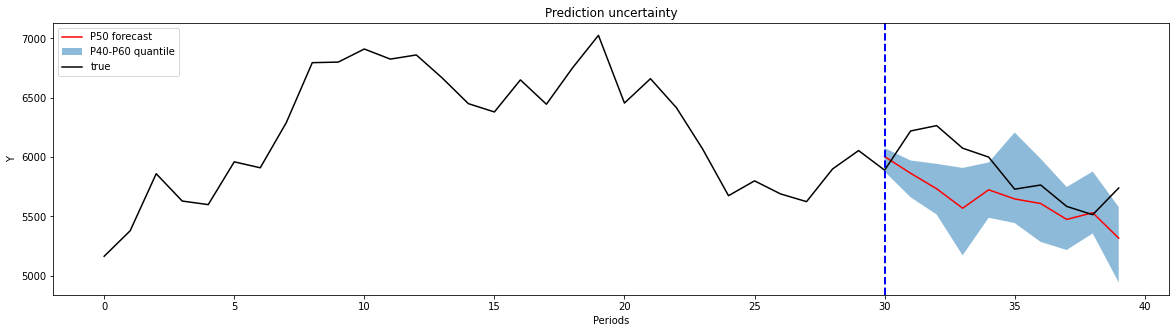

In [88]:
losses, mape_list, p50, Yf_true = train(train_data, test_data)

In [90]:
len(losses)

109

In [91]:
p50

array([6004.19189453, 5864.06054688, 5733.46630859, 5569.69995117,
       5724.68164062, 5647.66723633, 5609.10009766, 5475.1081543 ,
       5531.59179688, 5317.5144043 ])

In [92]:
Yf_true.ravel()

array([5890.    , 6220.    , 6264.9995, 6075.    , 6000.    , 5730.    ,
       5765.    , 5585.    , 5515.    , 5740.    ], dtype=float32)